In [1]:
import os
import glob
import random
from PIL import Image
import numpy as np
import cv2
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

### Data-Loading and Preprocessing 

In [8]:
DATA_DIR = './dataset_1' 
Train_dir = os.path.join(DATA_DIR, 'train')
Test_dir= os.path.join(DATA_DIR, 'test')

def get_file_paths(base_dir):
    
    paths = []
    patient_dirs = sorted(glob.glob(os.path.join(base_dir, '*')))
    for patient_dir in patient_dirs:
        img_files = sorted(glob.glob(os.path.join(patient_dir, 'img', '*.png')))
        mask_files = sorted(glob.glob(os.path.join(patient_dir, 'mask', '*.png')))
        if len(img_files) != len(mask_files):
            print(f"Warning: Mismatch in patient {os.path.basename(patient_dir)}")
            continue
        for img_path, mask_path in zip(img_files, mask_files):
            paths.append((img_path, mask_path))
    return paths


print("Finding train file paths...")
train_file_paths = get_file_paths(Train_dir)
#print(train_file_paths)
print("Finding test file paths...")
test_file_paths = get_file_paths(Test_dir) 
#print(test_file_paths[0])   

Finding train file paths...
Finding test file paths...


In [9]:
IMG_SIZE = 128
def preprocess_files(img_path, mask_path, target_size=(IMG_SIZE, IMG_SIZE)):
    """Loads, resizes, normalizes image, and binarizes mask using PIL."""
    try:
        # Load image (Grayscale)
        image = Image.open(img_path).convert("L")
        #mask = Image.open(mask_path).convert("L")
        #print(image.size,mask.size)
        #Resize Image (Bilinear interpolation) (for sanity check)
        image_resized = image.resize(target_size, Image.BILINEAR)
        image_np = np.array(image_resized, dtype=np.float32) / 255.0
        mask_cv = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        #print(np.unique(mask_cv))
        if mask_cv is None:
            raise IOError(f"cv2 failed to load mask: {mask_path}")
        #Resize Mask (Nearest neighbor interpolation)(for sanity check)
        mask_resized_cv = cv2.resize(mask_cv, target_size, interpolation=cv2.INTER_NEAREST)
        #print(np.unique(mask_resized_cv))
        #if(len(np.unique(mask_resized_cv))>1):print(img_path)

        # Add channel dimension (Height, Width) -> (Height, Width, Channels=1) preferred for PyTorch later
   
        image_final = np.expand_dims(image_np, axis=0)      # Shape: [1, H, W]
        mask_final = np.expand_dims(mask_resized_cv, axis=0)   # Shape: [1, H, W]

        return image_final, mask_final

    except Exception as e:
        print(f"Error processing pair: {img_path}, {mask_path} - {e}")
        return None, None


#img_test, mask_test = preprocess_files(train_file_paths[0][0], train_file_paths[0][1])     

In [11]:
# Process training data
train_images_list = []
train_masks_list = []
print(f"Preprocessing {len(train_file_paths)} training images/masks...")
for img_p, mask_p in tqdm(train_file_paths):
    img, mask = preprocess_files(img_p, mask_p)
    if img is not None and mask is not None:
        train_images_list.append(img)
        train_masks_list.append(mask)

# Process test data
test_images_list = []
test_masks_list = [] # Ground truth masks for evaluation
print(f"\nPreprocessing {len(test_file_paths)} test images/masks...")
for img_p, mask_p in tqdm(test_file_paths):
    img, mask = preprocess_files(img_p, mask_p)
    if img is not None and mask is not None:
        test_images_list.append(img)
        test_masks_list.append(mask)

Preprocessing 1847 training images/masks...


100%|██████████| 1847/1847 [00:00<00:00, 4553.57it/s]



Preprocessing 947 test images/masks...


100%|██████████| 947/947 [00:00<00:00, 4930.42it/s]


In [12]:
print(f"\n Initial Train images shape: {np.array(train_images_list).shape}") 
print(f" Initail Train masks shape: {np.array(train_masks_list).shape}")
train_images = np.stack(train_images_list, axis=0)
train_masks = np.stack(train_masks_list, axis=0)
print(f"\nTrain images shape: {train_images.shape}") # Should be [Num_Train_Slices, 1, IMG_SIZE, IMG_SIZE]
print(f"Train masks shape: {train_masks.shape}")


 Initial Train images shape: (1847, 1, 128, 128)
 Initail Train masks shape: (1847, 1, 128, 128)

Train images shape: (1847, 1, 128, 128)
Train masks shape: (1847, 1, 128, 128)


In [13]:
test_images = np.stack(test_images_list, axis=0)
test_masks = np.stack(test_masks_list, axis=0) # Ground truth test masks
print(f"Test images shape: {test_images.shape}")
print(f"Test masks shape: {test_masks.shape}")

Test images shape: (947, 1, 128, 128)
Test masks shape: (947, 1, 128, 128)


In [14]:
RANDOM_SEED = 42
if len(train_images) > 0:
     # Create indices to split based on
     indices = np.arange(len(train_images))
     train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=RANDOM_SEED)

     # Use indices to create actual train/validation sets
     X_train, X_val = train_images[train_indices], train_images[val_indices]
     y_train, y_val = train_masks[train_indices], train_masks[val_indices]

     print("\nSplitting training data (simple index split):")
     print(f"  X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
     print(f"  X_val shape: {X_val.shape},   y_val shape: {y_val.shape}")
else:
     print("\nCannot split training data as it's empty.")


# --- Sample Check ---
lesion_present=0
if len(train_images) > 0:
    print("\n--- Sample Check (from loaded NumPy array) ---")
    for i in range(len(train_masks)):
       if(len(np.unique(train_masks[i]))>1):
          #print(i)
          idx_check=i  
          lesion_present+=1
    print(idx_check)       
    print("Image shape:", train_images[idx_check].shape) # Should be [1, IMG_SIZE, IMG_SIZE]
    print("Mask shape:", train_masks[idx_check].shape)   # Should be [1, IMG_SIZE, IMG_SIZE]
    print("Image dtype:", train_images.dtype)            # Should be float32
    print("Mask dtype:", train_masks.dtype)              # Should be float32
    print("Image min/max:", np.min(train_images[idx_check]), np.max(train_images[idx_check])) # Should be [0, 1]
    print("Mask unique values:", np.unique(train_masks[idx_check])) 


Splitting training data (simple index split):
  X_train shape: (1477, 1, 128, 128), y_train shape: (1477, 1, 128, 128)
  X_val shape: (370, 1, 128, 128),   y_val shape: (370, 1, 128, 128)

--- Sample Check (from loaded NumPy array) ---
1842
Image shape: (1, 128, 128)
Mask shape: (1, 128, 128)
Image dtype: float32
Mask dtype: uint8
Image min/max: 0.0 1.0
Mask unique values: [0 1]


In [15]:
print(f"Ratio of images with non-empty lesions:{lesion_present/len(train_masks)}")

Ratio of images with non-empty lesions:0.48673524634542503


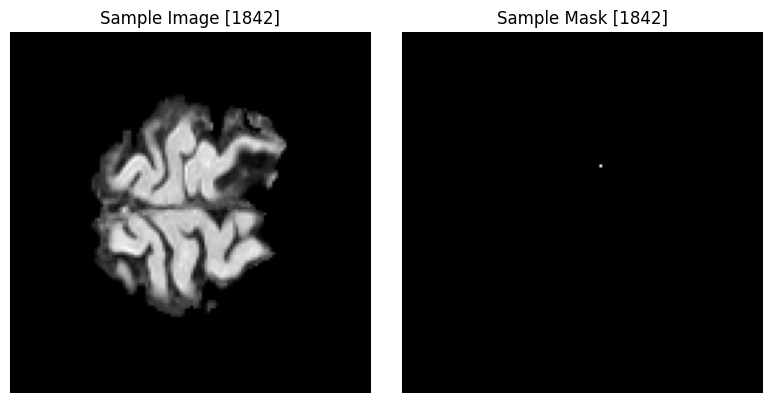

In [16]:
img_to_show = train_images[idx_check].squeeze() # Remove channel dim: [1, H, W] -> [H, W]
mask_to_show = train_masks[idx_check].squeeze() 

fig, ax = plt.subplots(1, 2, figsize=(8, 4)) # Create 1 row, 2 columns for plots

# Display Image
ax[0].imshow(img_to_show, cmap='gray')
ax[0].set_title(f'Sample Image [{idx_check}]')
ax[0].axis('off') 

# Display Mask
ax[1].imshow(mask_to_show, cmap='gray')
ax[1].set_title(f'Sample Mask [{idx_check}]')
ax[1].axis('off') 

plt.tight_layout() # Adjust spacing
plt.show()

### Part (a)

In [10]:
X_train_pixels = train_images.reshape(-1, 1)
y_train_pixels = train_masks.reshape(-1) # Flatten directly

print(f"Original pixel data shape: X={X_train_pixels.shape}, y={y_train_pixels.shape}")

Original pixel data shape: X=(30261248, 1), y=(30261248,)


In [11]:
sample_fraction = 0.5 # Use 100% of pixels for training
num_pixels_total = X_train_pixels.shape[0]
sample_size = int(num_pixels_total * sample_fraction)

print(f"Subsampling {sample_size} pixels ({sample_fraction*100:.1f}%) for training...")
np.random.seed(42) # For reproducible sampling
sample_indices = np.random.choice(num_pixels_total, sample_size, replace=False)

X_train_sampled = X_train_pixels[sample_indices]
y_train_sampled = y_train_pixels[sample_indices]

print(f"Sampled pixel data shape: X={X_train_sampled.shape}, y={y_train_sampled.shape}")

Subsampling 15130624 pixels (50.0%) for training...
Sampled pixel data shape: X=(15130624, 1), y=(15130624,)


In [12]:
# sample_fraction = 0.5 # Use 50% of pixels for training
# num_pixels_total = X_train_pixels.shape[0]
# sample_size = int(num_pixels_total * sample_fraction)

# print(f"Subsampling {sample_size} pixels ({sample_fraction*100:.1f}%) for training...")
# np.random.seed(42) # For reproducible sampling
# sample_indices_rf = np.random.choice(num_pixels_total, sample_size, replace=False)

# X_train_sampled_rf = X_train_pixels[sample_indices_rf]
# y_train_sampled_rf = y_train_pixels[sample_indices_rf]

# print(f"Sampled pixel data shape: X={X_train_sampled_rf.shape}, y={y_train_sampled_rf.shape}")

In [13]:
models = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1,algorithm='ball_tree'), # n_jobs=-1 uses all CPU cores
    'Random Forest': RandomForestClassifier(n_estimators=50, # Fewer trees for speed
                                            random_state=42,
                                            n_jobs=-1,
                                            max_depth=10, # Limit depth
                                            min_samples_split=100) # Prevent overfitting
}

print("Training Scikit-learn Models")
for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    # if(name=='Random Forest'):
    #     #print('yes')
    #     model.fit(X_train_sampled_rf, y_train_sampled_rf)
    #else:    
    model.fit(X_train_sampled, y_train_sampled)
    end_time = time.time()
    print(f"  Finished training {name} in {end_time - start_time:.2f} seconds.")

Training Scikit-learn Models
Training Naive Bayes...
  Finished training Naive Bayes in 0.36 seconds.
Training KNN...
  Finished training KNN in 3.66 seconds.
Training Random Forest...
  Finished training Random Forest in 166.29 seconds.


In [ ]:
sklearn_predictions = {} # Dictionary to store prediction arrays

print("\n--- Predicting on Test Set ---")
num_test_images = test_images.shape[0]

for name, model in models.items():
    print(f"Predicting with {name}...")
    # List to hold predicted masks for this model
    current_model_preds = []
    
    for i in tqdm(range(num_test_images)):
        # Get single test image and reshape for prediction
        test_img_single = test_images[i] # Shape [1, H, W]
        pixels_to_predict = test_img_single.reshape(-1, 1) # Shape [H*W, 1]

        # Predict class (0 or 1) for each pixel
        pred_pixels_flat = model.predict(pixels_to_predict) # Shape [H*W,]

        # Reshape flat predictions back to image mask format [1, H, W]
        pred_mask = pred_pixels_flat.reshape(1, IMG_SIZE, IMG_SIZE)
        current_model_preds.append(pred_mask)

    # Stack the list of predicted masks into a single NumPy array [N_test, 1, H, W]
    sklearn_predictions[name] = np.stack(current_model_preds, axis=0).astype(np.float32)
    print(f"  Finished predicting for {name}. Output shape: {sklearn_predictions[name].shape}")


--- Predicting on Test Set ---
Predicting with Naive Bayes...


100%|██████████| 947/947 [00:00<00:00, 3550.86it/s]


  Finished predicting for Naive Bayes. Output shape: (947, 1, 128, 128)
Predicting with KNN...


  0%|          | 0/947 [00:00<?, ?it/s]

### Part (b)

In [21]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 16 
NUM_EPOCHS = 10 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


#### Experiment 1:

In [22]:
#U-Net Model Definition (Adapted from milesial/Pytorch-UNet)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64 * factor, bilinear) # Corrected output channels for Up4
        self.outc = OutConv(64 * factor, n_classes) # Corrected input channels for OutConv


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [23]:
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_val_tensor = torch.from_numpy(X_val)
y_val_tensor = torch.from_numpy(y_val)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nCreated DataLoaders. Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


Created DataLoaders. Train batches: 93, Val batches: 24


In [24]:
model = UNet(n_channels=1, n_classes=1).to(DEVICE) # 1 input channel (grayscale), 1 output class (lesion mask)

#Binary Cross-Entropy with Logits

criterion = nn.BCEWithLogitsLoss()

# Optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)



train_losses = []
val_losses = []

print("\n--- Starting Training (Experiment 1: BCE + Adam) ---")
start_train_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
   
    model.train() # Set model to training mode
    running_train_loss = 0.0
    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)

    for inputs, masks in train_progress_bar:
        inputs = inputs.to(DEVICE)
        masks = masks.to(DEVICE).float()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs) # Output raw logits

        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        train_progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False)

    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, masks in val_progress_bar:
            inputs = inputs.to(DEVICE)
            masks = masks.to(DEVICE).float()

            outputs = model(inputs)
            loss = criterion(outputs, masks)

            running_val_loss += loss.item() * inputs.size(0)
            val_progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    epoch_end_time = time.time()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Time: {epoch_end_time - epoch_start_time:.2f}s")

    

end_train_time = time.time()
print(f"--- Finished Training --- Total Time: {end_train_time - start_train_time:.2f}s")


--- Starting Training (Experiment 1: BCE + Adam) ---


Epoch 1/10 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/10 - Train Loss: 0.3810, Val Loss: 0.3341, Time: 491.85s


Epoch 2/10 - Train Loss: 0.2307, Val Loss: 0.2158, Time: 492.99s


Epoch 3/10 - Train Loss: 0.1707, Val Loss: 0.1507, Time: 444.90s


Epoch 4/10 - Train Loss: 0.1324, Val Loss: 0.1166, Time: 462.78s


Epoch 5/10 - Train Loss: 0.1066, Val Loss: 0.1133, Time: 460.33s


Epoch 6/10 - Train Loss: 0.0873, Val Loss: 0.0767, Time: 456.31s


Epoch 7/10 - Train Loss: 0.0711, Val Loss: 0.0635, Time: 516.81s


Epoch 8/10 - Train Loss: 0.0589, Val Loss: 0.0648, Time: 425.87s


Epoch 9/10 - Train Loss: 0.0514, Val Loss: 0.0470, Time: 405.92s


Epoch 10/10 - Train Loss: 0.0423, Val Loss: 0.0393, Time: 410.44s
--- Finished Training --- Total Time: 4568.21s


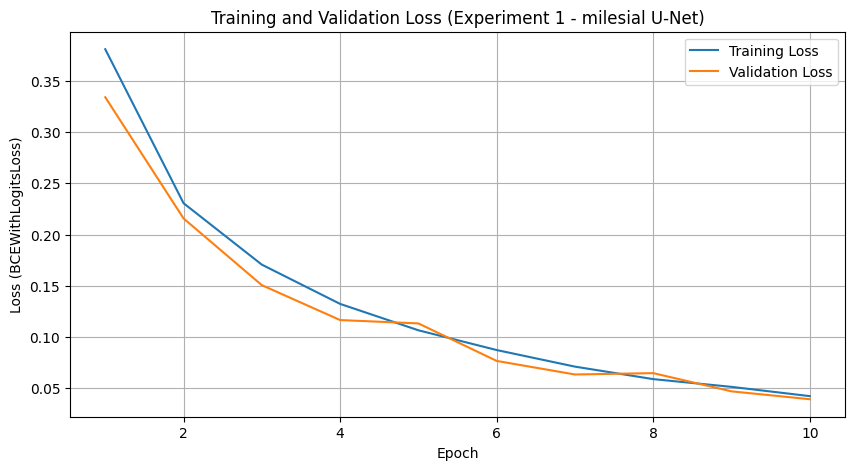


Training for Experiment 1 (milesial U-Net) complete.


In [25]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (BCEWithLogitsLoss)')
plt.title('Training and Validation Loss (Experiment 1 - milesial U-Net)')
plt.legend()
plt.grid(True)
plt.show()

print("\nTraining for Experiment 1 (milesial U-Net) complete.")

In [ ]:

MODEL_SAVE_PATH = "unet_experiment1_best.pth" 

print(f"\n--- Saving Model ---")

torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model state_dict saved to: {MODEL_SAVE_PATH}")

print("\n--- Verifying Model Loading ---")


print("Creating a new model instance...")
new_model = UNet(n_channels=1, n_classes=1, bilinear=True).to(DEVICE) 


print(f"Loading state_dict from: {MODEL_SAVE_PATH}")
new_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE)) 
print("State_dict loaded successfully.")


new_model.eval()
print("Loaded model set to evaluation mode.")
print("\nModel saving and loading verification complete.")




--- Saving Model ---
Model state_dict saved to: unet_experiment1_best.pth

--- Verifying Model Loading ---
Creating a new model instance...
Loading state_dict from: unet_experiment1_best.pth
State_dict loaded successfully.
Loaded model set to evaluation mode.

Model saving and loading verification complete.
